# **California Housing Price (Supervised: Regression)**

- Target: median_house_value
- Feature:
    - longitude
    - latitude
    - housing_median_age
    - total_rooms
    - total_bedrooms
    - population
    - households
    - median_income
    - ocean_proximity
    

## **Business Problem Understanding**
**Context**

The California Housing Price dataset contains information from the 1990 California census. It provides details about housing conditions across different districts, including geographic location, housing characteristics, demographics, and proximity to the ocean. While the data is outdated, it is widely used as a learning resource for machine learning, especially for building regression models to predict housing prices based on various features.

Determining the right house price is a critical factor in the real estate industry. An overpriced house might take a long time to sell, while an underpriced house may lead to reduced profit for the owner. Many factors influence the value of a house, such as location, size, number of bedrooms, population density, and average household income. Understanding these factors can greatly assist property owners, developers, and buyers in making better decisions.

**Problem Statement**

The main challenge in the housing market is determining a fair and competitive house price based on its characteristics. Homeowners and real estate agents often struggle to set the optimal selling price due to significant differences between properties, even within the same area. Without accurate pricing guidance, the listing price might deviate from the actual market value.

**Goals**

Build a regression model that can predict the median house value (`median_house_value`) based on various housing and neighborhood characteristics. This model is expected to help:
- Homeowners set competitive prices.
- Real estate agents recommend appropriate selling or buying prices.
- Potential buyers assess the fair value of a property.

**Analytic Approach**

The steps to be taken include:
1. **Exploratory Data Analysis (EDA)** to understand feature-target relationships and patterns.
2. **Data preprocessing** including handling missing values, encoding categorical variables, and scaling/normalizing features if needed.
3. **Model building** using various regression algorithms (Ridge, Random Forest Regressor, XGBoost, LightGBM, Gradient Boosting).
4. **Model evaluation** to select the most accurate and robust model.


### **Data Understanding**
- The dataset contains housing data from the California 1990 census.
- Each row represents a district’s housing and demographic information.

**Attributes Information**

| **Attribute** | **Data Type** | **Description** |
| --- | --- | --- |
| longitude | Float | Longitude coordinate of the district |
| latitude | Float | Latitude coordinate of the district |
| housing_median_age | Float | Median age of houses in the district |
| total_rooms | Float | Total number of rooms in the district |
| total_bedrooms | Float | Total number of bedrooms in the district |
| population | Float | Total population in the district |
| households | Float | Total number of households in the district |
| median_income | Float | Median household income in the district (in tens of thousands of USD) |
| ocean_proximity | Object | Categorical variable indicating proximity to the ocean |
| median_house_value | Float | Median house value in the district (USD) |

### **Modeling Plan**
The modeling process will follow these steps:

1. **Data Preprocessing**
   - Handle missing values in `total_bedrooms`.
   - Encode categorical feature `ocean_proximity` using one-hot encoding.
   - Filling missing value using KNN Imputer.
   - Apply feature scaling for models sensitive to data scale.

2. **Baseline Model**
   - Train a simple **Ridge Regression**, **Random Forest**, **XGBoost** and **LightGBM** models to establish baseline performance.
   - Record RMSE, MAE, and MAPE.

3. **Model Stacking Experimentation**
   - **Random Forest Regressor** for non-linear relationships and feature importance analysis.
   - **Gradient Boosting Models** for potentially higher accuracy.

4. **Model Evaluation**
   - Compare performance across all models using cross-validation.
   - Select the best model based on the lowest RMSE and MAPE, balanced with interpretability.

5. **Final Model Deployment**
   - Retrain the best model on the entire training dataset.
   - Save the model for future inference.

### **Evaluation Metrics**

| **Metric** | **Function** | **Reason for Use in This Dataset** | **Interpretation** |
| --- | --- | --- | --- |
| **RMSE** (Root Mean Squared Error) | Measures the square root of the average squared differences between predicted and actual values. Penalizes large errors more heavily. | In housing price prediction, very large errors (e.g., hundreds of thousands USD off) can be highly impactful. RMSE ensures the model avoids such large deviations, especially in high-value areas like coastal districts. | RMSE of 50,000 means the model’s predictions deviate by an average of $50K from the actual median house price. |
| **MAE** (Mean Absolute Error) | Measures the average of absolute differences between predicted and actual values. Treats all errors equally. | Provides a more “realistic” view of the model’s performance across all districts, without being overly affected by extremely expensive or cheap houses. | MAE of 40,000 means predictions are off by $40K on average. |
| **MAPE** (Mean Absolute Percentage Error) | Measures the average percentage error between predicted and actual values. | Allows stakeholders to understand model accuracy in relative terms. Important because the same dollar error has different impacts for cheap vs. expensive houses. | MAPE of 8% means the model is, on average, 8% off from the actual house price. |

## Import Dependencies

In [1]:
# Basic data manipulation & visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Warning control
import warnings
warnings.filterwarnings("ignore")

# Data splitting
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Regression Models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Ensemble model
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor

# SHAP Analysis
import shap 

# Save model
import joblib


## Load Dataset

In [2]:
df = pd.read_csv('data_california_house.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
3,-118.28,34.06,17.0,2518.0,1196.0,3051.0,1000.0,1.7199,<1H OCEAN,175000.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14448 entries, 0 to 14447
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           14448 non-null  float64
 1   latitude            14448 non-null  float64
 2   housing_median_age  14448 non-null  float64
 3   total_rooms         14448 non-null  float64
 4   total_bedrooms      14311 non-null  float64
 5   population          14448 non-null  float64
 6   households          14448 non-null  float64
 7   median_income       14448 non-null  float64
 8   ocean_proximity     14448 non-null  object 
 9   median_house_value  14448 non-null  float64
dtypes: float64(9), object(1)
memory usage: 1.1+ MB


In [4]:
df.shape

(14448, 10)

In [5]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14448.000000,14448.000000,14448.000000,14448.000000,14311.000000,14448.000000,14448.000000,14448.000000,14448.000000
mean,-119.566647,35.630093,28.618702,2640.132683,538.260709,1425.157323,499.508929,3.866667,206824.624516
std,2.006587,2.140121,12.596694,2191.612441,423.577544,1149.580157,383.098390,1.891158,115365.476182
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1451.000000,295.000000,784.000000,279.000000,2.570600,119600.000000
50%,-118.490000,34.260000,29.000000,2125.000000,435.000000,1165.000000,410.000000,3.539100,180000.000000
75%,-118.000000,37.710000,37.000000,3148.000000,647.000000,1724.000000,604.000000,4.736100,263900.000000
max,-114.310000,41.950000,52.000000,32627.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
df.describe(include= 'object')

,ocean_proximity
count,14448
unique,5
top,<1H OCEAN
freq,6369


In [7]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     6369
INLAND        4576
NEAR OCEAN    1879
NEAR BAY      1622
ISLAND           2
Name: count, dtype: int64

In [8]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        137
population              0
households              0
median_income           0
ocean_proximity         0
median_house_value      0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(0)

We found that there is one column with missing values: total_bedrooms, which has 137 missing entries.

There are no duplicate records in the dataset.

## EDA

### Numerical Columns

In [10]:
# Create variable for numerical colummns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

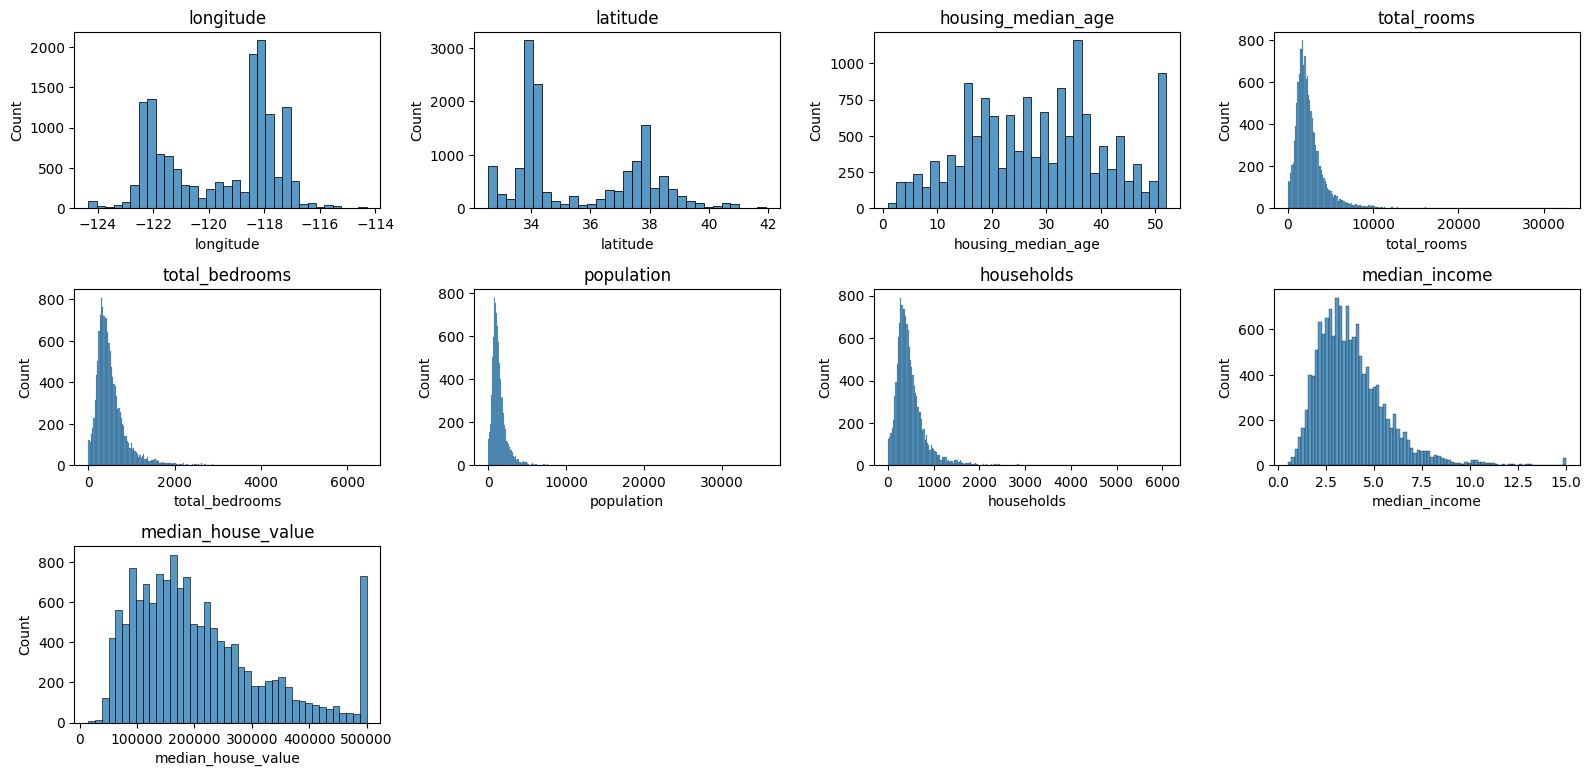

In [11]:
# Histogram for numerical columns
plt.figure(figsize=(16,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 4, i)
    sns.histplot(df, x= col)
    plt.title(col)

plt.tight_layout()

In [12]:
# Check skewness
hist_skew = {
    'Column' : num_cols,
    'Skewness' : df[num_cols].skew().values.round(3)
}

df_hist_skew = pd.DataFrame(hist_skew)
df_hist_skew

,Column,Skewness
0,longitude,-0.304
1,latitude,0.471
2,housing_median_age,0.059
3,total_rooms,3.983
4,total_bedrooms,3.387
5,population,5.458
6,households,3.346
7,median_income,1.629
8,median_house_value,0.982


**Histogram Distribution Insights**

1. **longitude**  
   - Distribution is multimodal, showing several peaks that represent clusters of districts in specific areas of California.  
   - Values range from approximately -124 to -114, consistent with California’s geographic boundaries.

2. **latitude**  
   - Distribution is also multimodal, with large peaks around 34 and 37 degrees latitude.  
   - Indicates population concentration in major metropolitan areas such as Los Angeles and the San Francisco Bay Area.

3. **housing_median_age**  
   - Relatively uniform distribution with peaks at specific ages such as 20, 30, and 50 years.  
   - Many districts have a median housing age of 50, possibly due to an upper recording limit in the census.

4. **total_rooms**  
   - Highly right-skewed distribution.  
   - Most districts have fewer than 5,000 total rooms, but there are outliers with extremely high counts.

5. **total_bedrooms**  
   - Similar right-skewed pattern as total_rooms.  
   - Majority of districts have fewer than 1,000 total bedrooms.

6. **population**  
   - Strongly right-skewed distribution.  
   - Most districts have populations below 5,000, but some densely populated districts exceed 30,000 residents.

7. **households**  
   - Right-skewed distribution.  
   - Most districts have fewer than 2,000 households, though some exceed 6,000.

8. **median_income**  
   - Slightly right-skewed distribution, with most median household incomes between 2 and 6 (tens of thousands USD).  
   - A small number of districts have exceptionally high median incomes (>12).

9. **median_house_value**  
   - Right-skewed distribution, peaking around $100K–$200K.  
   - Many data points are capped at $500K, suggesting the presence of an upper limit in census recording.


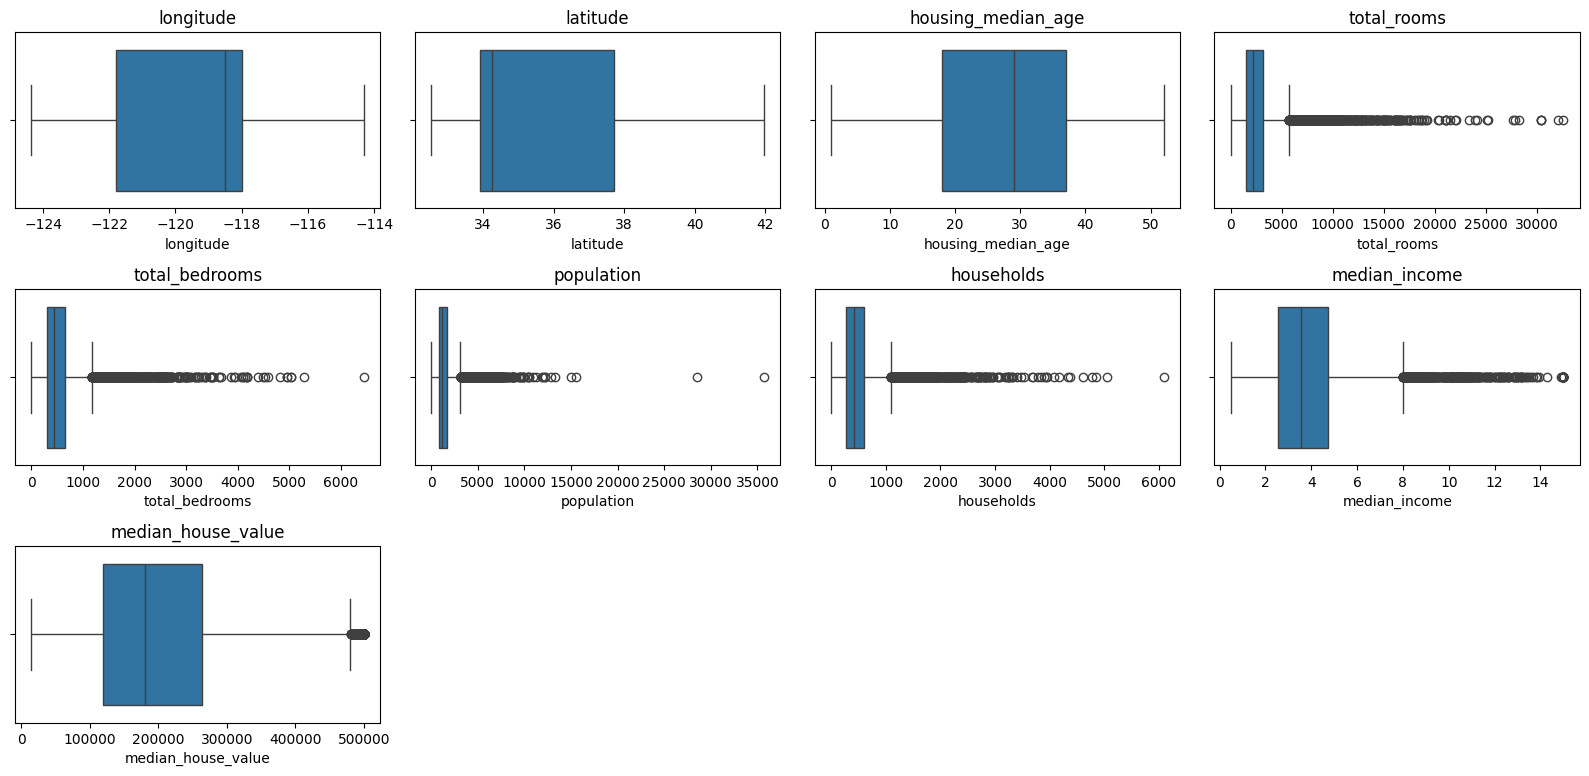

In [13]:
# Boxplot for numerical columns
plt.figure(figsize=(16,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(df, x= col)
    plt.title(col)

plt.tight_layout()

**Boxplot & Outlier Analysis**

1. **longitude & latitude**  
   - No significant outliers detected; distribution aligns with California’s geographic boundaries.

2. **housing_median_age**  
   - Few outliers present; notable clustering at the maximum value (50 years).

3. **total_rooms, total_bedrooms, population, households**  
   - Large number of high-value outliers.  
   - Indicates the presence of districts with unusually high housing capacity, population density, or household count compared to the majority.

4. **median_income**  
   - Outliers on the right side represent high-income districts, potentially urban or affluent neighborhoods.

5. **median_house_value**  
   - Outliers appear on the right, with many values at the $500K ceiling, indicating potential **censoring** in the dataset.

### Identify Outlier

In [14]:
# Checking contextual outlier with ocean_proximity
context_col = 'ocean_proximity'
rows = []

for col in num_cols:
    if col == context_col:
        continue
    
    # Global outlier
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    global_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    
    # Contextual outlier per category
    for cat in df[context_col].unique():
        subset = df[df[context_col] == cat]
        Q1_c = subset[col].quantile(0.25)
        Q3_c = subset[col].quantile(0.75)
        IQR_c = Q3_c - Q1_c
        lower_c = Q1_c - 1.5 * IQR_c
        upper_c = Q3_c + 1.5 * IQR_c
        context_count = subset[(subset[col] < lower_c) | (subset[col] > upper_c)].shape[0]
        
        rows.append({
            'Column': col,
            'Outlier Type': 'Global',
            'Category': 'All Data',
            'Count': global_count
        })
        
        rows.append({
            'Column': col,
            'Outlier Type': 'Contextual',
            'Category': cat,
            'Count': context_count
        })

# Convert to DataFrame
df_outlier = pd.DataFrame(rows)
df_outlier

,Column,Outlier Type,Category,Count
0,longitude,Global,All Data,0
1,longitude,Contextual,INLAND,0
2,longitude,Global,All Data,0
3,longitude,Contextual,NEAR BAY,0
4,longitude,Global,All Data,0
...,...,...,...,...
85,median_house_value,Contextual,<1H OCEAN,423
86,median_house_value,Global,All Data,757
87,median_house_value,Contextual,NEAR OCEAN,0
88,median_house_value,Global,All Data,757


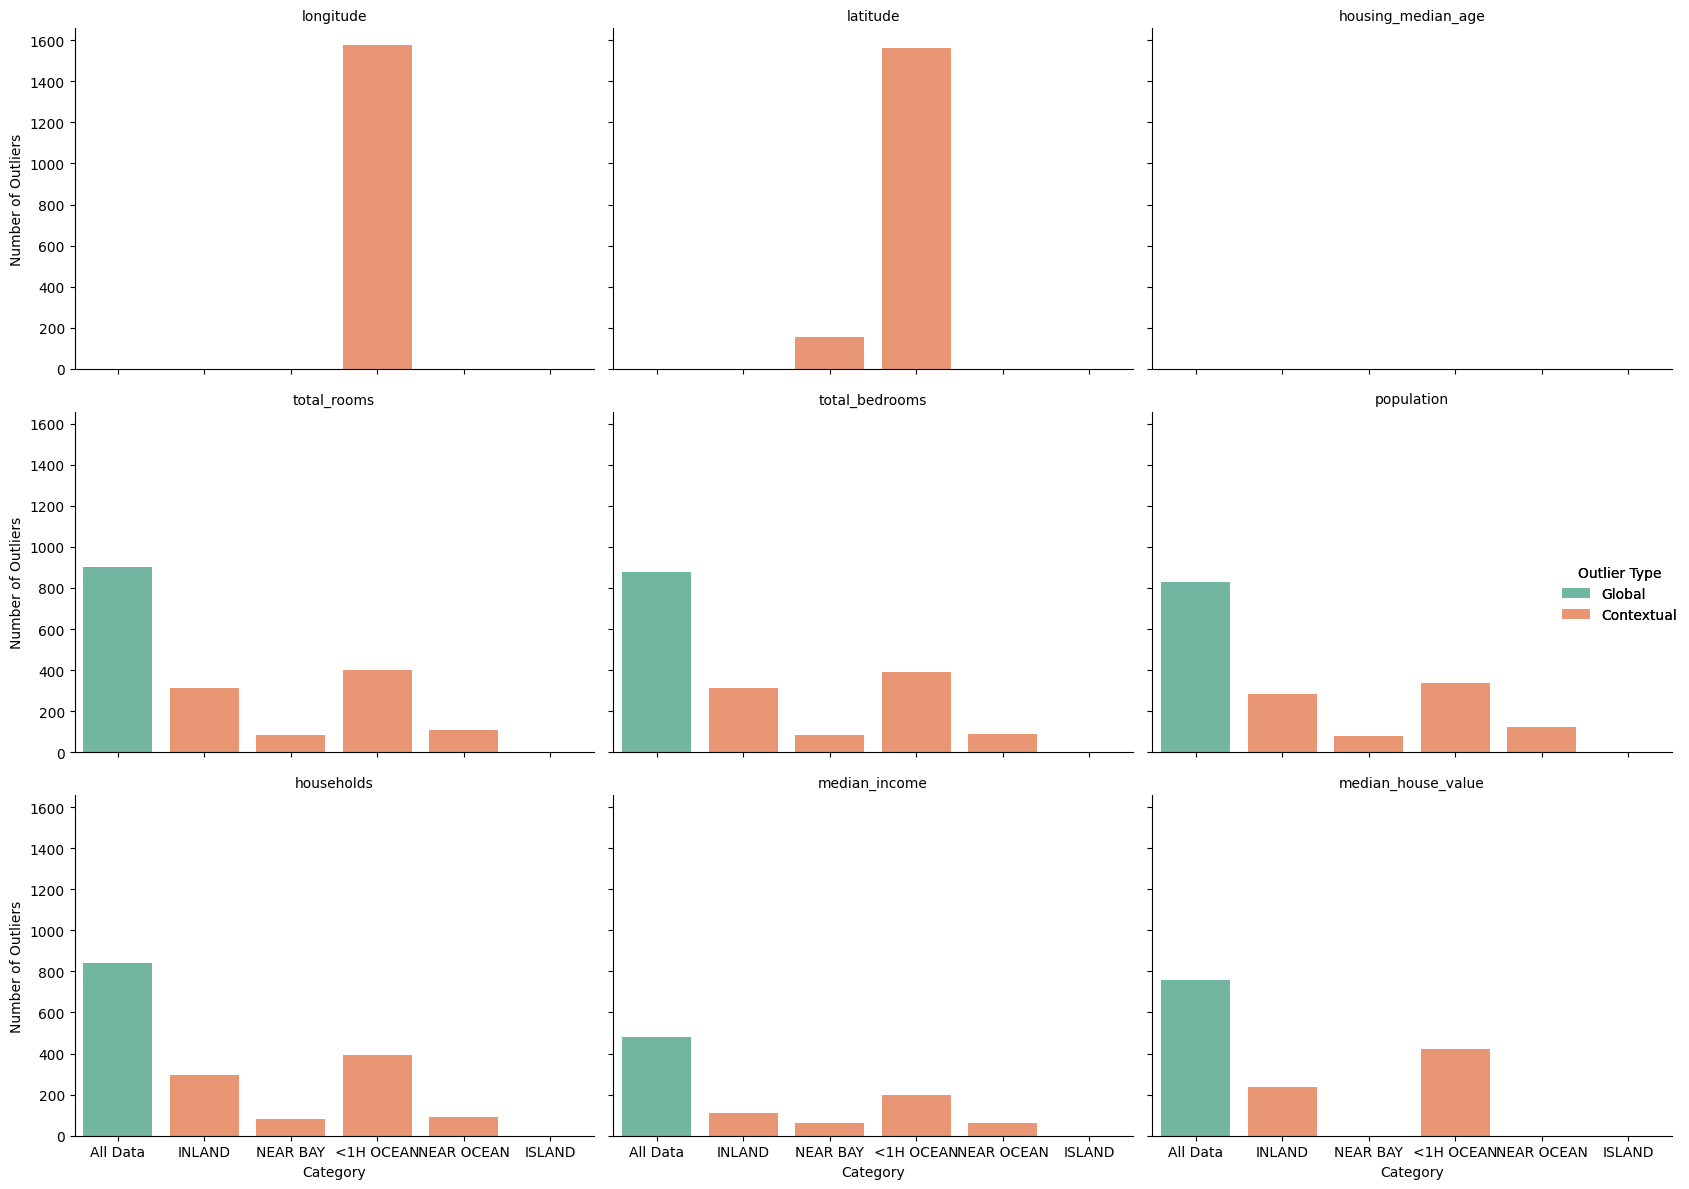

In [15]:
outlier = sns.catplot(
    data=df_outlier,
    x= 'Category',
    y= 'Count',
    hue= 'Outlier Type',
    col= 'Column',          
    col_wrap= 3,            
    kind= 'bar',
    palette= 'Set2',
    height= 4,
    aspect= 1.2
)
outlier.set_titles("{col_name}")
outlier.set_axis_labels("Category", "Number of Outliers")
outlier.add_legend(title="Outlier Type")
plt.tight_layout()


In [16]:
summary_table = df_outlier.pivot_table(
    index='Column',
    columns='Outlier Type',
    values='Count',
    aggfunc='sum',
    fill_value=0
).reset_index()

summary_table

Outlier Type,Column,Contextual,Global
0,households,858,4210
1,housing_median_age,0,0
2,latitude,1717,0
3,longitude,1579,0
4,median_house_value,658,3785
5,median_income,438,2410
6,population,824,4135
7,total_bedrooms,878,4395
8,total_rooms,901,4500


**Insights from the visualization**
- **Longitude & Latitude** → Only contextual outliers, no global ones. This means the extreme values appear due to differences in distribution across `ocean_proximity` categories, not because the absolute values are inherently abnormal.  
- **Total Rooms, Total Bedrooms, Population, Households, Median Income, Median House Value** → Significant global outliers (`All Data` in green) indicate that these values are extreme across the entire dataset, not just in specific categories.  
- **Housing Median Age** → No outliers detected.  
- High **contextual** outlier counts in certain categories (e.g., `NEAR BAY` for `total_rooms`) suggest that the category has a narrower distribution, making some values that are normal globally appear extreme in that specific context.  

In [17]:
# List of numerical features to check for global outliers
features_to_clean = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']

df_clean = df.copy()

for col in features_to_clean:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove global outliers (outside IQR bounds)
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print(f"Original data shape: {df.shape}")
print(f"After removing global outliers: {df_clean.shape}")

Original data shape: (14448, 10)
After removing global outliers: (12185, 10)


In [18]:
df_clean.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
0,-119.79,36.73,52.0,112.0,28.0,193.0,40.0,1.9750,INLAND,47500.0
1,-122.21,37.77,43.0,1017.0,328.0,836.0,277.0,2.2604,NEAR BAY,100000.0
2,-118.04,33.87,17.0,2358.0,396.0,1387.0,364.0,6.2990,<1H OCEAN,285800.0
4,-119.81,36.73,50.0,772.0,194.0,606.0,167.0,2.2206,INLAND,59200.0
7,-121.26,38.69,17.0,3917.0,638.0,1809.0,564.0,5.2586,INLAND,137000.0


In [19]:
df_clean.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,12185.000000,12185.000000,12185.000000,12185.000000,12185.000000,12185.000000,12185.000000,12185.000000,12185.000000
mean,-119.619536,35.702245,29.890685,2083.037833,428.445055,1140.181781,400.502667,3.636801,196379.213049
std,2.006175,2.167305,12.276566,1030.073246,202.550987,548.119931,187.321466,1.488608,107045.623724
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.810000,33.940000,20.000000,1358.000000,282.000000,748.000000,267.000000,2.514800,114100.000000
50%,-118.620000,34.360000,31.000000,1947.000000,404.000000,1074.000000,380.000000,3.458300,174100.000000
75%,-118.030000,37.740000,38.000000,2701.000000,558.000000,1492.000000,522.000000,4.576900,251000.000000
max,-114.550000,41.950000,52.000000,5688.000000,1047.000000,2720.000000,913.000000,7.983500,500001.000000


In [20]:
# # Save cleaned dataset
# df_clean.to_csv("data_california_house_cleaned.csv", index=False)

### Correlation Heatmap

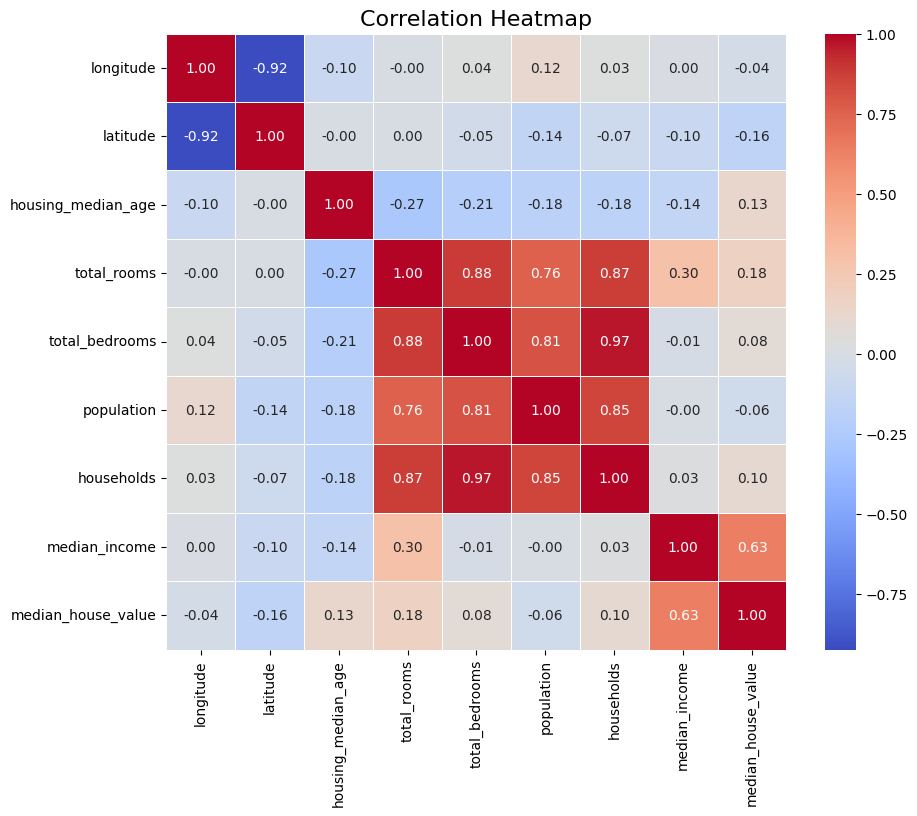

In [21]:
corr = df_clean[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

**Correlation Heatmap Insights**

1. **Strong Positive Correlations**
- **`total_rooms` ↔ `total_bedrooms`** (0.88)  
  These features are highly correlated, suggesting they capture very similar information. This could cause multicollinearity issues in regression models.  
- **`total_rooms` ↔ `households`** (0.87) and **`total_bedrooms` ↔ `households`** (0.98)  
  Areas with more households tend to have proportionally more rooms and bedrooms.  
- **`population` ↔ `households`** (0.85)  
  More households generally mean a higher population, which is intuitive.  

2. **Strong Negative Correlations**
- **`longitude` ↔ `latitude`** (-0.92)  
  This strong inverse relationship is likely due to the geographical distribution of locations in the dataset (possibly specific to California).  

3. **Key Relationships with Target (`median_house_value`)**
- **`median_income` ↔ `median_house_value`** (0.63)  
  Income is the most influential feature on house value in this dataset. Higher income areas tend to have higher house prices.  
- All other correlations with `median_house_value` are relatively weak (< 0.18), meaning location and population variables alone don’t strongly predict price without other factors.  

4. **Modeling Considerations**
- To address multicollinearity, Ridge Regression, Random Forest, XGBoost, LightGBM and Gradient Boosting will be used as trial models, as they can handle correlated features to some extent, though redundant variables may still introduce noise.


**Dropping `latitude` and `longitude`**
- The features latitude and longitude will be excluded from the modeling process because, in their raw form, they show weak correlations with the target variable (latitude: -0.16, longitude: -0.04) and are highly correlated with each other (-0.92). 
- Additionally, raw geographic coordinates are not inherently meaningful for the models unless transformed into more informative features such as distance measures, regional clusters, or categorical locations. 
- By removing them, we simplify the feature set, maintain interpretability, and focus on variables with stronger direct predictive value, while still capturing geographic effects indirectly through other  features such as population density, proximity to coast, or regional median income.


### Categorical Column

Text(0.5, 0, 'Ocean Proximity')

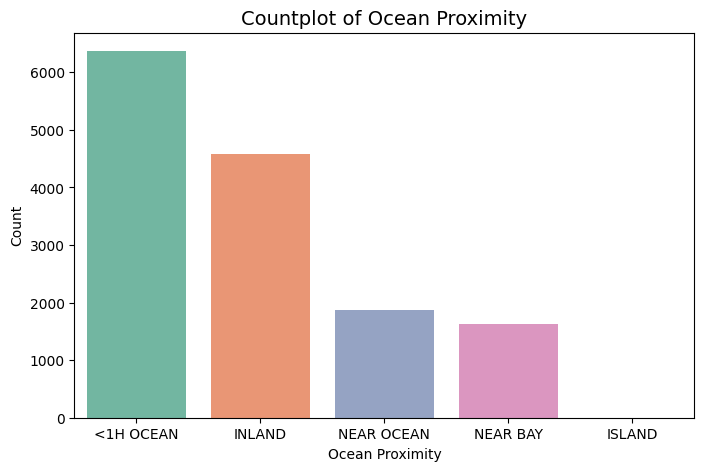

In [22]:
# Countplot
plt.figure(figsize=(8, 5))
order = df['ocean_proximity'].value_counts().index
ax = sns.countplot(data=df, x='ocean_proximity', order=order, palette="Set2")
plt.title("Countplot of Ocean Proximity", fontsize=14)
plt.ylabel("Count")
plt.xlabel("Ocean Proximity")


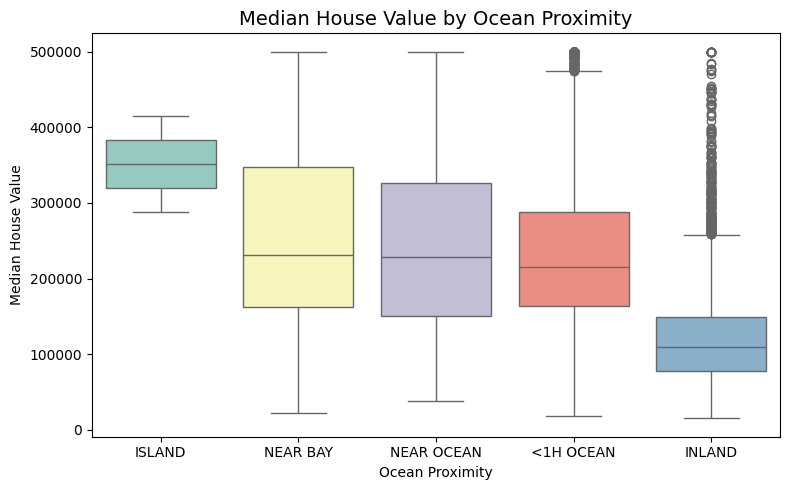

In [23]:
# Boxplot
plt.figure(figsize=(8, 5))
order = df.groupby('ocean_proximity')['median_house_value'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='ocean_proximity', y='median_house_value', order=order, palette='Set3')
plt.title("Median House Value by Ocean Proximity", fontsize=14)
plt.ylabel("Median House Value")
plt.xlabel("Ocean Proximity")
plt.tight_layout()

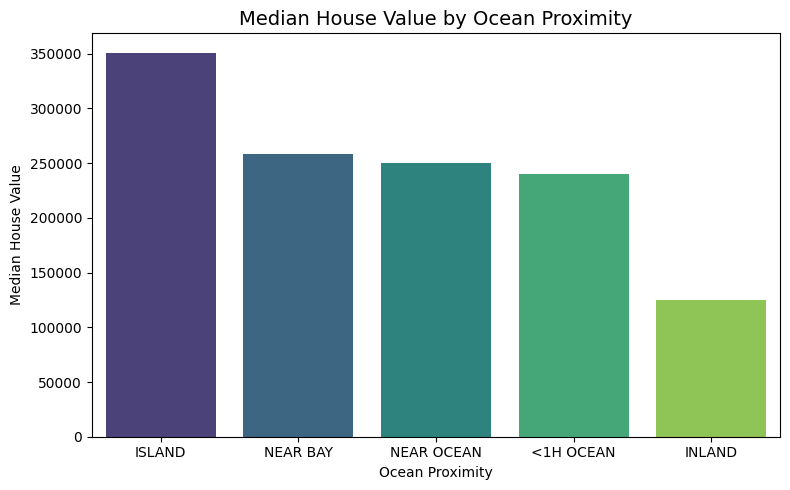

In [24]:
# Barplot
plt.figure(figsize=(8, 5))
order = df.groupby('ocean_proximity')['median_house_value'].median().sort_values(ascending=False).index
sns.barplot(data=df, x='ocean_proximity', y='median_house_value', order=order, palette='viridis', ci=None)
plt.title("Median House Value by Ocean Proximity", fontsize=14)
plt.ylabel("Median House Value")
plt.xlabel("Ocean Proximity")
plt.tight_layout()


**Insights: Ocean Proximity Analysis**

**1. Countplot**
- The dataset is dominated by properties **`<1H OCEAN`** (less than one hour to the ocean), making up the largest portion of listings.  
- Other notable categories include **`INLAND`**, which has the second-largest share.  
- Categories such as **`ISLAND`** and **`NEAR BAY`** have significantly fewer properties, which may impact statistical stability for these groups.  
- This uneven distribution suggests that the model may be more influenced by categories with higher representation unless balanced through preprocessing or weighting.

**2. Boxplot: Ocean Proximity vs. Median House Value**
- Properties in **`ISLAND`** and **`NEAR OCEAN`** categories generally have **higher median house values**, with several high-value outliers.  
- **`INLAND`** properties show the lowest median values and a narrower interquartile range, indicating less price variation compared to coastal areas.  
- The wide spread and multiple outliers in **`<1H OCEAN`** suggest high variability in property prices, possibly due to mixed urban and suburban locations within this category.

**3. Barplot (Median Values)**
- Ranking by median house value:
    1. **`ISLAND`** – highest median prices, possibly driven by limited supply and high desirability.
    2. **`NEAR OCEAN`** – second highest, reflecting the premium of direct coastal proximity.
    3. **`<1H OCEAN`** – moderate median prices but with substantial variation.
    4. **`NEAR BAY`** – slightly lower median values compared to oceanfront properties.
    5. **`INLAND`** – lowest median house values.
- This trend reinforces the strong relationship between coastal proximity and property prices in California, which can be a key predictor in the regression model.


## Define Feature (X) and Target (y)

In [25]:
X = df_clean.drop(columns=["median_house_value", "latitude", "longitude"])
y = df_clean['median_house_value']

## Data Splitting

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0,
)

## Preprocessing

In [27]:
# Identify columns
num_col = X.select_dtypes(include=np.number).columns.tolist()
num_col

['housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income']

In [28]:
cat_col = X.select_dtypes(exclude=np.number).columns.tolist()
cat_col

['ocean_proximity']

### Pipeline

In [29]:
# Numerical Pipeline
numeric_transformer = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

# Categorical pipeline
categoric_transformer = Pipeline([
    ('encoder', OneHotEncoder(drop= 'first', handle_unknown= 'ignore'))
])

In [30]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_col),
    ('cat', categoric_transformer, cat_col)
], remainder= 'passthrough')

preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,n_neighbors,5
,weights,'uniform'


In [31]:
# Fit preprocessor to X_train
preprocessor.fit(X_train)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,n_neighbors,5
,weights,'uniform'


In [32]:
# Transform preprocessor to X_train and X_test
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [33]:
# Convert to DataFrame
df_X_train = pd.DataFrame(X_train_prep, columns=preprocessor.get_feature_names_out())
df_X_test = pd.DataFrame(X_test_prep, columns=preprocessor.get_feature_names_out())

df_X_train

,num__housing_median_age,num__total_rooms,num__total_bedrooms,num__population,num__households,num__median_income,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN
0,-0.166667,-0.193380,-0.275362,-0.406996,-0.277344,-0.372488,1.0,0.0,0.0,0.0
1,-0.444444,-0.841205,-0.887681,-0.941137,-0.875000,1.195711,0.0,0.0,1.0,0.0
2,0.166667,-0.653775,-0.626812,-0.039691,-0.589844,-0.193151,0.0,0.0,0.0,0.0
3,-0.833333,-0.636668,-0.804348,-0.377397,-0.765625,0.591383,1.0,0.0,0.0,0.0
4,0.388889,-0.134623,-0.025362,-0.316852,0.082031,-0.744446,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
9743,-0.833333,0.530309,0.713768,1.206189,0.804688,0.237925,0.0,0.0,0.0,0.0
9744,0.833333,-0.029007,0.137681,-0.127144,0.230469,-0.088244,0.0,0.0,0.0,1.0
9745,0.055556,-0.213462,-0.271739,0.069290,-0.351562,-0.130265,1.0,0.0,0.0,0.0
9746,0.000000,0.008925,-0.213768,-0.116381,-0.226562,0.570614,0.0,0.0,0.0,0.0


## Modeling

In [34]:
# Baseline model
models = {
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1)
}

In [35]:
results = []

for name, model in models.items():
    model.fit(X_train_prep, y_train)
    y_pred = model.predict(X_test_prep)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100


    results.append({
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE").round(2)
results_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 9748, number of used features: 9
[LightGBM] [Info] Start training from score 196313.792778


,Model,RMSE,MAE,MAPE (%)
3,LightGBM,61061.95,43212.85,26.74
1,Random Forest,62584.90,44091.44,26.66
2,XGBoost,62819.07,44074.22,26.98
0,Ridge Regression,67573.84,49736.94,30.56


## **Baseline Model Performance**

1. **LightGBM**
   - RMSE: **61,061.95**, MAE: **43,212.85**, MAPE: **26.74%**
   - Achieves the lowest RMSE among all baseline models, showing excellent predictive accuracy.
   - Handles large datasets efficiently and captures both linear and non-linear relationships.
   - Strong candidate for both standalone use and as part of an ensemble due to speed and accuracy balance.

2. **Random Forest**
   - RMSE: **62,584.90**, MAE: **44,091.44**, MAPE: **26.66%**
   - Slightly higher RMSE compared to LightGBM, but still very competitive.
   - Excels at modeling complex feature interactions and non-linearities.
   - Stable baseline model with robust performance across different data splits.

3. **XGBoost**
   - RMSE: **62,819.07**, MAE: **44,074.22**, MAPE: **26.98%**
   - Performance closely matches Random Forest, with only marginal differences.
   - Known for strong performance in tabular data and effective handling of overfitting through regularization.
   - Slightly slower than LightGBM but can provide better generalization with tuned parameters.

4. **Ridge Regression**
   - RMSE: **67,573.84**, MAE: **49,736.94**, MAPE: **30.56%**
   - Performs worse than tree-based models but remains useful for its simplicity and interpretability.
   - Effectively mitigates multicollinearity, producing stable coefficients.
   - Better suited for situations where model transparency is a priority over maximum predictive power.


## Hyperparameter Tuning

In [36]:
# Param grid 
param_grid = {
    "Ridge Regression": {
        "model": Ridge(),
        "params": {
            "alpha": [0.1, 1.0, 10, 50]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20],
            "max_features": ["sqrt", "log2"]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [3, 5, 7],
            "learning_rate": [0.03, 0.05, 0.1]
        }
    },
    "LightGBM": {
        "model": LGBMRegressor(random_state=42, n_jobs=-1),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [-1, 10, 20],
            "learning_rate": [0.03, 0.05, 0.1]
        }
    }
}


In [37]:
# Tuning
tuning_results = []
model_tuned = {}

for name, mp in param_grid.items():
    print(f"Tuning {name}...")
    grid = GridSearchCV(
        mp["model"], 
        mp["params"], 
        scoring="neg_root_mean_squared_error", 
        cv=5, 
        n_jobs=-1
    )
    grid.fit(X_train_prep, y_train)
    
    best_model = grid.best_estimator_
    model_tuned[name] = best_model
    
    y_pred = best_model.predict(X_test_prep)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100

    tuning_results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE (%)": mape
    })

tuning_df = pd.DataFrame(tuning_results).sort_values(by="RMSE").round(2)
tuning_df

Tuning Ridge Regression...
Tuning Random Forest...
Tuning XGBoost...
Tuning LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 9748, number of used features: 9
[LightGBM] [Info] Start training from score 196313.792778


,Model,Best Params,RMSE,MAE,MAPE (%)
3,LightGBM,"{'learning_rate': 0.03, 'max_depth': -1, 'n_es...",61013.30,43344.24,26.72
2,XGBoost,"{'learning_rate': 0.03, 'max_depth': 7, 'n_est...",61556.79,43263.03,26.33
1,Random Forest,"{'max_depth': None, 'max_features': 'sqrt', 'n...",61849.88,43784.70,26.82
0,Ridge Regression,{'alpha': 1.0},67573.84,49736.94,30.56


In [39]:
# Models with best parameters
model_tuned

{'Ridge Regression': Ridge(),
 'Random Forest': RandomForestRegressor(max_features='sqrt', n_estimators=300, n_jobs=-1,
                       random_state=42),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...),
 'LightGBM': LGBMRegressor(learning_rate=0.03, n_estimators=200, n_jobs=

In [40]:
# Comparing model before and after hyperparameter tuning
comparison_df = results_df.merge(
    tuning_df[["Model", "RMSE", "MAE", "MAPE (%)"]],
    on="Model",
    suffixes=("_Before", "_After")
).round(2)

comparison_df

,Model,RMSE_Before,MAE_Before,MAPE (%)_Before,RMSE_After,MAE_After,MAPE (%)_After
0,LightGBM,61061.95,43212.85,26.74,61013.30,43344.24,26.72
1,Random Forest,62584.90,44091.44,26.66,61849.88,43784.70,26.82
2,XGBoost,62819.07,44074.22,26.98,61556.79,43263.03,26.33
3,Ridge Regression,67573.84,49736.94,30.56,67573.84,49736.94,30.56


**Hyperparameter Tuning Insights**

1. **LightGBM**  
   - RMSE improved slightly from **61,061.95** to **61,013.30**.  
   - MAE changed from **43,212.85** to **43,344.24** (small increase, negligible).  
   - MAPE moved marginally from **26.74%** to **26.72%**.  
   - Indicates the model was already near-optimal before tuning, with minimal benefit from parameter adjustments.

2. **Random Forest**  
   - RMSE improved from **62,584.90** to **61,849.88**.  
   - MAE improved slightly from **44,091.44** to **43,784.70**.  
   - MAPE changed marginally from **26.66%** to **26.82%** (small increase, negligible).  
   - Gains likely came from tuning parameters such as `n_estimators`, `max_depth`, and `max_features`, improving prediction stability.

3. **XGBoost**  
   - RMSE improved notably from **62,819.07** to **61,556.79**.  
   - MAE improved from **44,074.22** to **43,263.03**.  
   - MAPE reduced from **26.98%** to **26.33%**, showing better relative accuracy.  
   - Gains achieved through tuning parameters like `n_estimators`, `max_depth`, and `learning_rate`, improving both bias and variance.

4. **Ridge Regression**  
   - No change in performance (RMSE: **67,573.84** → **67,573.84**, MAE: **49,736.94** → **49,736.94**, MAPE: **30.56%** → **30.56%**).  
   - Suggests the initial `alpha` parameter was already optimal for this dataset.  
   - Performance lags behind tree-based models despite stability.

---

### **Conclusion**
- **LightGBM** remains the top performer in RMSE with stable results before and after tuning.  
- **XGBoost** shows the largest post-tuning improvement, closing in on LightGBM’s performance.  
- **Random Forest** is still strong but slightly behind the boosting models.  
- **Ridge Regression** is stable and interpretable but less competitive in predictive accuracy compared to tree-based approaches.


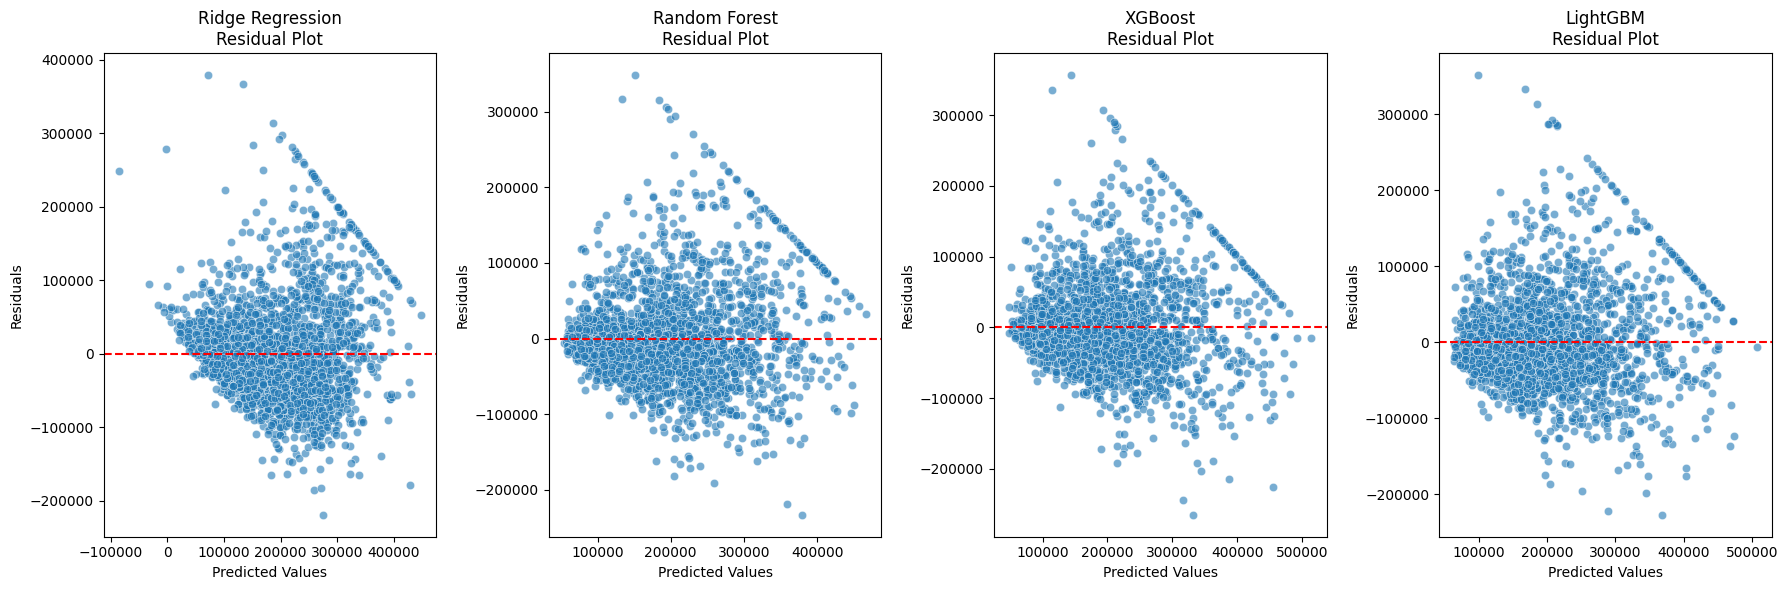

In [47]:
# Residual Plot
plt.figure(figsize=(18, 6))

for i, (name, model) in enumerate(model_tuned.items()):
    y_pred = model.predict(X_test_prep)
    residuals = y_test - y_pred
    
    plt.subplot(1, len(model_tuned), i + 1)
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(y=0, color="red", linestyle="--")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title(f"{name}\nResidual Plot")

plt.tight_layout()

**Residual Plot Analysis**

1. **Ridge Regression**  
   - Shows a clear triangular pattern in residuals, indicating heteroscedasticity.  
   - Error spread increases for higher predicted values, suggesting difficulty in capturing variability in high-priced houses.  
   - Residuals are symmetrically distributed around zero, indicating no major systematic bias, but variance grows with the target magnitude.

2. **Random Forest**  
   - Still exhibits heteroscedasticity, but less pronounced than in Ridge Regression.  
   - Errors are smaller for mid-range predictions but increase for very high-value houses, highlighting limited extrapolation ability.  
   - Performs better in modeling non-linear patterns, though high-end outliers remain challenging.

3. **XGBoost**  
   - Residuals are more evenly spread compared to Random Forest, indicating better capability in modeling price variability.  
   - While heteroscedasticity is still present, its degree is lower than in Ridge Regression.  
   - Consistent distribution of residuals around zero suggests lower bias and good prediction stability.

4. **LightGBM**  
   - Residual plot closely resembles XGBoost, with relatively uniform spread and mild heteroscedasticity.  
   - Effectively captures complex patterns in the data, though very high-value outliers still result in large errors.  
   - Consistent distribution around zero indicates a good balance between bias and variance.


## Ensemble Model

### Stacking with Random Forest

In [48]:
# Define model
stacking_rf = StackingRegressor(
    estimators=[(name.lower().replace(" ", "_"), est) for name, est in model_tuned.items()],
    final_estimator=RandomForestRegressor(random_state=42),
    n_jobs=-1
)
stacking_rf

,estimators,"[('ridge_regression', ...), ('random_forest', ...), ...]"
,final_estimator,RandomForestR...ndom_state=42)
,cv,None
,n_jobs,-1
,passthrough,False
,verbose,0
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001


In [49]:
# Fit
stacking_rf.fit(X_train_prep, y_train)

# Predict
y_pred_stack_rf = stacking_rf.predict(X_test_prep)

# Evaluation
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_stack_rf))
mae_rf = mean_absolute_error(y_test, y_pred_stack_rf)
mape_rf = mean_absolute_percentage_error(y_test, y_pred_stack_rf) * 100

print("=== Stacking (Meta Model: Random Forest) ===")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"MAPE: {mape_rf:.2f}%")

=== Stacking (Meta Model: Random Forest) ===
RMSE: 62153.18
MAE: 44353.13
MAPE: 27.06%


### Stacking with Gradient Boost

In [54]:
# Define model
stacking_gb = StackingRegressor(
    estimators=[(name.lower().replace(" ", "_"), est) for name, est in model_tuned.items()],
    final_estimator= GradientBoostingRegressor(random_state=42),
    n_jobs=-1
)

stacking_gb

,estimators,"[('ridge_regression', ...), ('random_forest', ...), ...]"
,final_estimator,GradientBoost...ndom_state=42)
,cv,None
,n_jobs,-1
,passthrough,False
,verbose,0
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001


In [51]:
# Fit
stacking_gb.fit(X_train_prep, y_train)

# Predict
y_pred_stack_gb = stacking_gb.predict(X_test_prep)

# Evaluation
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_stack_gb))
mae_gb = mean_absolute_error(y_test, y_pred_stack_gb)
mape_gb = mean_absolute_percentage_error(y_test, y_pred_stack_gb) * 100

print("=== Stacking (Meta Model: Gradient Boosting) ===")
print(f"RMSE: {rmse_gb:.2f}")
print(f"MAE: {mae_gb:.2f}")
print(f"MAPE: {mape_gb:.2f}%")


=== Stacking (Meta Model: Gradient Boosting) ===
RMSE: 60835.58
MAE: 42942.13
MAPE: 26.13%


### Stacking with XGBoost

In [60]:
# Define model
stacking_xgb = StackingRegressor(
    estimators=[(name.lower().replace(" ", "_"), est) for name, est in model_tuned.items()],
    final_estimator= XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=2,
    subsample=1,
    colsample_bytree=1,
    random_state=42,
    n_jobs=-1
),
    n_jobs=-1
)

stacking_xgb

,estimators,"[('ridge_regression', ...), ('random_forest', ...), ...]"
,final_estimator,"XGBRegressor(...ree=None, ...)"
,cv,None
,n_jobs,-1
,passthrough,False
,verbose,0
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001


In [61]:
# Fit
stacking_xgb.fit(X_train_prep, y_train)

# Predict
y_pred_stack_xgb = stacking_xgb.predict(X_test_prep)

# Evaluation
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_stack_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_stack_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_stack_xgb) * 100

print("=== Stacking (Meta Model: XGBoosting) ===")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"MAPE: {mape_xgb:.2f}%")


=== Stacking (Meta Model: XGBoosting) ===
RMSE: 61040.36
MAE: 43099.15
MAPE: 26.11%


### Stacking with LightGBM

In [62]:
stacking_lgbm = StackingRegressor(
    estimators=[(name.lower().replace(" ", "_"), est) for name, est in model_tuned.items()],
    final_estimator= LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=31,
    subsample=1.0,
    colsample_bytree=1.0,
    random_state=42,
    n_jobs=-1
),
    n_jobs=-1
)

stacking_lgbm

,estimators,"[('ridge_regression', ...), ('random_forest', ...), ...]"
,final_estimator,LGBMRegressor...ndom_state=42)
,cv,None
,n_jobs,-1
,passthrough,False
,verbose,0
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001


In [63]:
# Fit
stacking_lgbm.fit(X_train_prep, y_train)

# Predict
y_pred_stack_lgbm = stacking_lgbm.predict(X_test_prep)

# Evaluation
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_stack_lgbm))
mae_lgbm = mean_absolute_error(y_test, y_pred_stack_lgbm)
mape_lgbm = mean_absolute_percentage_error(y_test, y_pred_stack_lgbm) * 100

print("=== Stacking (Meta Model: lgbmoosting) ===")
print(f"RMSE: {rmse_lgbm:.2f}")
print(f"MAE: {mae_lgbm:.2f}")
print(f"MAPE: {mape_lgbm:.2f}%")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 9748, number of used features: 4
[LightGBM] [Info] Start training from score 196313.792778
=== Stacking (Meta Model: lgbmoosting) ===
RMSE: 61970.40
MAE: 43590.25
MAPE: 26.25%


### Meta-model comparison

In [64]:
stacking_results = pd.DataFrame({
    "Model": ["Stacking (Random Forest)", "Stacking (Gradient Boost)", "Stacking (XGBoost)", "Stacking (LightGBM)"],
    "RMSE": [rmse_rf, rmse_gb, rmse_xgb, rmse_lgbm],
    "MAE": [mae_rf, mae_gb, mae_xgb, mae_lgbm],
    "MAPE (%)": [mape_rf, mape_gb, mape_xgb, mape_lgbm]
}).sort_values(by="RMSE").round(2)

stacking_results

,Model,RMSE,MAE,MAPE (%)
1,Stacking (Gradient Boost),60835.58,42942.13,26.13
2,Stacking (XGBoost),61040.36,43099.15,26.11
3,Stacking (LightGBM),61970.40,43590.25,26.25
0,Stacking (Random Forest),62153.18,44353.13,27.06


**Ensemble Model Comparison Insights**

1. **Stacking (Gradient Boost)** delivers the best overall performance among the tested meta-models:
   - **RMSE**: 60,835.58 — lowest error, indicating the highest predictive accuracy.
   - **MAE**: 42,942.13 — smallest average error magnitude.
   - **MAPE**: 26.13% — lowest relative error percentage, improving reliability for different value ranges.

2. **Stacking (XGBoost)** comes in a close second:
   - Slightly higher RMSE (**61,040.36**) and MAE (**43,099.15**) than Gradient Boost.
   - MAPE is marginally lower (**26.11%**), showing competitive relative accuracy.
   - The minimal gap suggests XGBoost is a strong alternative when training speed or parameter flexibility is a priority.

3. **Stacking (LightGBM)** ranks third:
   - **RMSE**: 61,970.40, **MAE**: 43,590.25, and **MAPE**: 26.25%.
   - Still competitive, but slightly behind in all metrics compared to Gradient Boost and XGBoost.
   - May be more efficient in large-scale datasets due to faster training.

4. **Stacking (Random Forest)** performs the weakest in this setup:
   - **RMSE**: 62,153.18, **MAE**: 44,353.13, and **MAPE**: 27.06% — highest across all metrics.
   - Likely due to redundancy when combining multiple tree-based models, limiting additional learning benefits.

---

**Conclusion:**  
For this dataset, **Stacking with Gradient Boosting as the meta-model** is the most effective choice, achieving the best results in RMSE, MAE, and MAPE. **XGBoost** is a close contender, while **LightGBM** remains a solid, efficient option. **Random Forest** underperforms as a meta-model in this specific ensemble configuration.


### Residual Plot

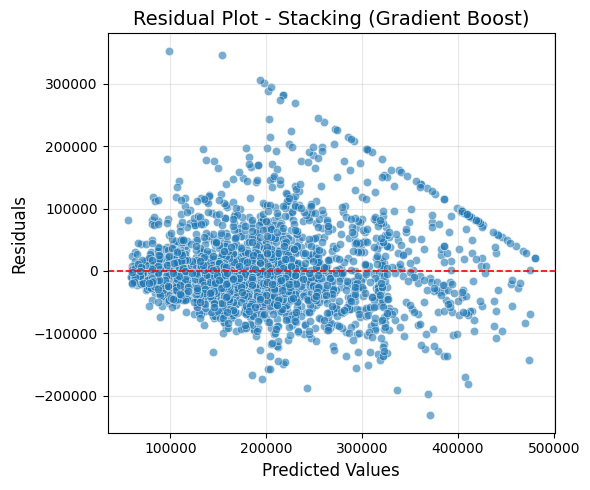

In [65]:
y_pred_final = stacking_gb.predict(X_test_prep) 
residuals_final = y_test - y_pred_final

plt.figure(figsize=(6, 5))
sns.scatterplot(x=y_pred_final, y=residuals_final, alpha=0.6)
plt.axhline(y=0, color="red", linestyle="--", linewidth=1.2)
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Residual Plot - Stacking (Gradient Boost)", fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## **Residual Plot Analysis — Stacking (Gradient Boost)**

- **Centering & Bias**  
  Residuals are well-centered around zero, indicating the model is generally **unbiased** in its predictions. There is no strong sign of systematic overestimation or underestimation.

- **Heteroscedasticity**  
  Residual spread widens as predicted values increase, showing **heteroscedasticity**. This pattern is typical in housing price prediction, where higher-priced properties have greater variability.

- **Outliers**  
  Several extreme residuals appear on both ends, likely representing properties with unique features or market conditions not fully captured by the model.

- **Model Fit Observation**  
  The triangular residual distribution is less prominent than in pure tree-based models, suggesting improved handling of continuous target values and reduced overfitting compared to models like Random Forest alone.

**Conclusion**  
The residual distribution indicates that **Stacking (Gradient Boost)** effectively models most of the variance in the target while keeping predictions balanced. Addressing heteroscedasticity — for example, by applying a log transformation to the target variable — could further reduce RMSE and improve prediction stability.

### **Final Model Recommendation**

## 1. **Baseline Model Performance**
| Model             | RMSE      | MAE       | MAPE (%) |
|-------------------|-----------|-----------|----------|
| LightGBM          | **61,061.95** | **43,212.85** | **26.74** |
| Random Forest     | 62,584.90 | 44,091.44 | 26.66    |
| XGBoost           | 62,819.07 | 44,074.22 | 26.98    |
| Ridge Regression  | 67,573.84 | 49,736.94 | 30.56    |

- **LightGBM** starts with the best baseline performance across RMSE, MAE, and MAPE.
- **Random Forest** and **XGBoost** follow closely, both handling nonlinear patterns well.
- **Ridge Regression** is the most stable but less accurate compared to tree-based models.

---

## 2. **After Hyperparameter Tuning**
| Model            | RMSE      | MAE       | MAPE (%) |
|------------------|-----------|-----------|----------|
| LightGBM         | **61,013.30** | 43,344.24 | 26.72    |
| XGBoost          | 61,556.79 | **43,263.03** | **26.33** |
| Random Forest    | 61,849.88 | 43,784.70 | 26.82    |
| Ridge Regression | 67,573.84 | 49,736.94 | 30.56    |

- **LightGBM** achieves the lowest RMSE post-tuning, making it slightly ahead in predictive accuracy.
- **XGBoost** secures the best MAE and MAPE, showing consistent error minimization across predictions.
- **Random Forest** follows closely behind, still competitive but slightly less accurate.
- **Ridge Regression** lags behind tree-based models in all metrics.

---

## 3. **Ensemble Model Comparison**
| Model                     | RMSE      | MAE       | MAPE (%) |
|---------------------------|-----------|-----------|----------|
| Stacking (Gradient Boost) | **60,835.58** | **42,942.13** | **26.13** |
| Stacking (XGBoost)        | 61,040.36 | 43,099.15 | 26.11    |
| Stacking (LightGBM)       | 61,970.40 | 43,590.25 | 26.25    |
| Stacking (Random Forest)  | 62,153.18 | 44,353.13 | 27.06    |

- **Stacking (Gradient Boost)** achieves the best RMSE and MAE among all tested meta-models, slightly edging out Stacking (XGBoost).
- **Stacking (XGBoost)** is nearly as good, with a marginally better MAPE but slightly higher RMSE.
- **Stacking (LightGBM)** remains competitive but trails behind in all metrics.
- **Stacking (Random Forest)** performs the weakest, likely due to redundancy with other tree-based base models.

---

## **Recommendation**
- **Best Performing Model:** **Stacking (Gradient Boost)**  
  - RMSE: **60,835.58**  
  - MAE: **42,942.13**  
  - MAPE: **26.13%**
- **Why:** Captures both linear and nonlinear relationships effectively, improves prediction stability, and reduces residual error compared to individual tuned models.
- **Alternative Choice:** **Stacking (XGBoost)** for a close trade-off in performance with potentially more flexibility in tuning.
- **Next Steps:**  
  1. Finalize and save the **Stacking (Gradient Boost)** pipeline with preprocessing steps embedded.  
  2. Deploy the model to the production environment.  
  3. Monitor post-deployment metrics for drift or degradation in accuracy.


## Final Pipeline for Deployment

In [66]:
# Final pipeline: preprocessing + model
final_pipeline = Pipeline([
    ("preprocessor", preprocessor),   
    ("model", stacking_gb)            
])

final_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## SHAP Analysis

In [68]:
# Extract the stacking model (the "model" step in final_pipeline)
stacking_model = final_pipeline.named_steps["model"]
stacking_model

,estimators,"[('ridge_regression', ...), ('random_forest', ...), ...]"
,final_estimator,GradientBoost...ndom_state=42)
,cv,None
,n_jobs,-1
,passthrough,False
,verbose,0
,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001


In [69]:
# List of base models and meta-model
base_estimators = stacking_model.estimators_
meta_model = stacking_model.final_estimator_

# Preprocess X
X_processed = final_pipeline.named_steps["preprocessor"].transform(X)

# Create meta-features: predictions from each base model
meta_features = {}
for idx, est in enumerate(base_estimators):
    name = est[0] if isinstance(est, tuple) else est.__class__.__name__
    model = est[1] if isinstance(est, tuple) else est
    preds = model.predict(X_processed)
    meta_features[name] = preds

meta_X = pd.DataFrame(meta_features)
meta_X.head()


,Ridge,RandomForestRegressor,XGBRegressor,LGBMRegressor
0,90806.322896,65795.666667,79314.843750,87232.030835
1,178629.412573,115871.666667,112385.468750,121633.002564
2,287226.799652,285290.336667,283392.031250,278393.346365
3,104814.346379,69289.000000,78526.070312,86488.009534
4,184278.269144,147191.666667,169410.640625,172281.599435


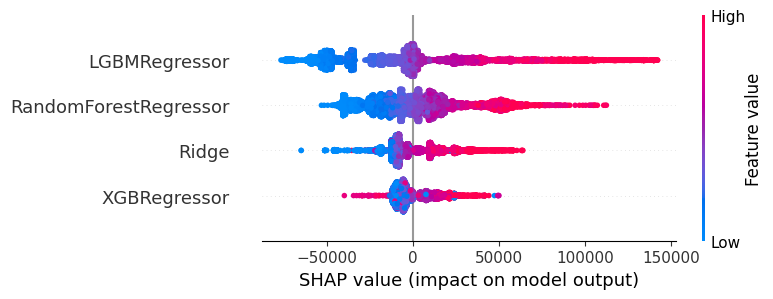

In [70]:
# SHAP Analysis
shap.initjs()
explainer = shap.TreeExplainer(meta_model)  
shap_values = explainer.shap_values(meta_X)

# Summary plot
shap.summary_plot(shap_values, meta_X)

## **1. SHAP Summary Plot – Base Model Contributions**

### **Key Insights**
- **LGBMRegressor** shows the strongest and most consistent influence on the stacking meta-model’s predictions, as evidenced by the wide spread of SHAP values both positively and negatively.  
- **RandomForestRegressor** also plays a major role, contributing substantially to prediction variability, with a balanced spread on both sides of the SHAP axis.
- **Ridge** has a smaller yet noticeable influence, mainly providing stability rather than large swings in predictions.
- **XGBRegressor** appears to have the least impact among the base learners, but still adds diversity to the ensemble’s decision-making.
- **Color Gradient (Blue → Red):**  
  - **Blue dots** indicate lower predictions from the base model, generally pulling the final output lower.  
  - **Red dots** indicate higher predictions from the base model, generally pushing the final output higher.

**Interpretation:**  
The meta-model relies most heavily on **LGBMRegressor** and **RandomForestRegressor** when forming its final predictions, using **Ridge** and **XGBRegressor** to refine and balance results rather than dominate them.


In [75]:
stacking_model.estimators[3]

('lightgbm',
 LGBMRegressor(learning_rate=0.03, n_estimators=200, n_jobs=-1, random_state=42))

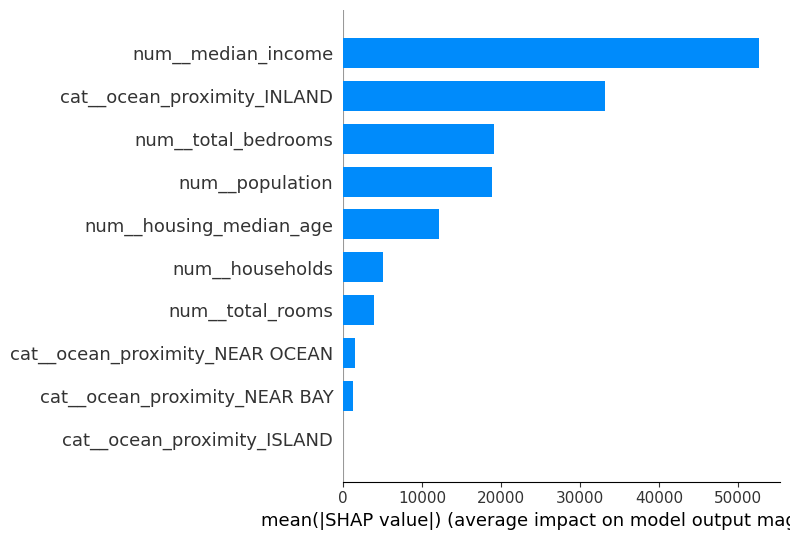

In [76]:
# Summary plot feature importance 
lgbm_model = stacking_model.estimators[3][1]
preprocessor = final_pipeline.named_steps["preprocessor"]

X_processed = preprocessor.transform(X)
feature_names = preprocessor.get_feature_names_out()

shap.initjs()
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(pd.DataFrame(X_processed, columns=feature_names))

# Bar chart SHAP
shap.summary_plot(
    shap_values,
    pd.DataFrame(X_processed, columns=feature_names),
    plot_type="bar"
)

## 2. **SHAP Feature Importance Analysis**

The SHAP summary plot shows the mean absolute contribution of each feature to the LightGBM model’s predictions for median house value.

**Key Insights:**
- **`num__median_income`** is the most influential feature by a wide margin, reinforcing the strong positive relationship between household income and housing prices.
- **`cat__ocean_proximity_INLAND`** ranks second, highlighting the significant price gap between inland areas and coastal locations—properties further from the ocean tend to have lower predicted values.
- **`num__total_bedrooms`** and **`num__population`** hold similar influence, suggesting that both housing supply and population density contribute meaningfully to price variation.
- **`num__housing_median_age`** shows a moderate effect, indicating that the age of housing stock impacts valuation, though less than location or income.
- **`num__households`** and **`num__total_rooms`** contribute modestly, suggesting secondary importance in price prediction.
- Other categories of **`cat__ocean_proximity`** (`NEAR OCEAN`, `NEAR BAY`, `ISLAND`) have minimal average SHAP values, indicating weaker direct influence compared to inland vs. coastal differentiation.

**Conclusion:**
The model places strongest emphasis on **income** and **inland/coastal location**, with demographic and housing structure variables playing a supporting role.


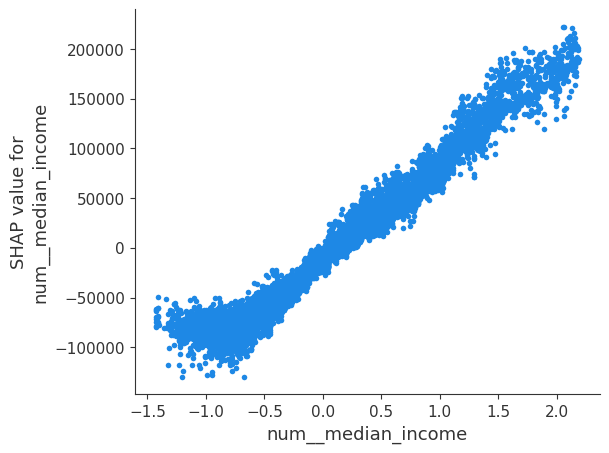

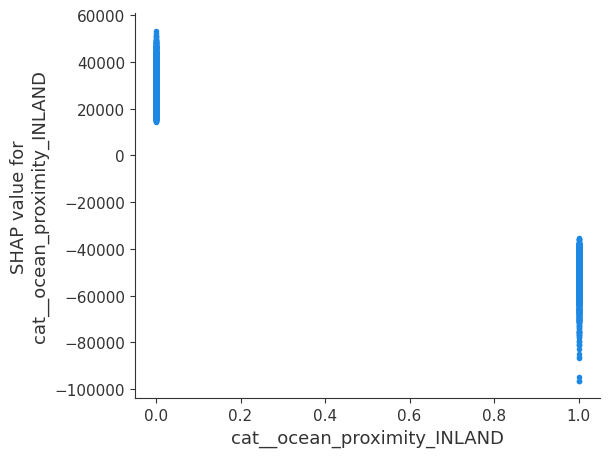

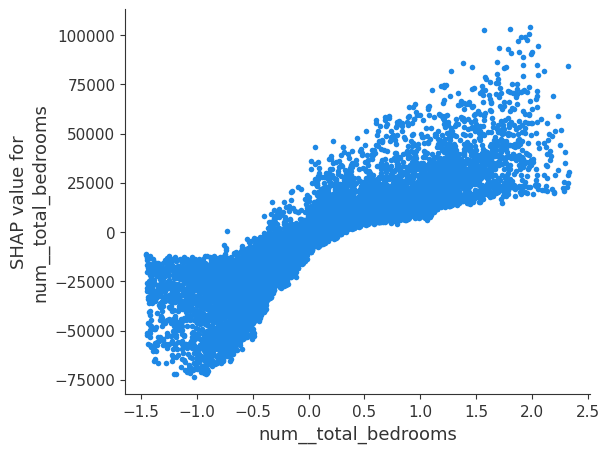

In [ ]:
# SHAP dependence plot for the top 3 feature
shap.initjs()
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(pd.DataFrame(X_processed, columns=feature_names))

top_features = ["num__median_income", "cat__ocean_proximity_INLAND", "num__total_bedrooms"]

for feat in top_features:
    shap.dependence_plot(
        feat,
        shap_values,
        pd.DataFrame(X_processed, columns=feature_names),
        interaction_index=None 
    )

**3. SHAP Dependence Plot Analysis**  
The SHAP dependence plots illustrate how changes in each top feature influence the model’s prediction of median house value.

**Key Insights:**

- **`num__median_income`**  
  There is a strong positive relationship between median income and predicted house prices. As standardized median income increases, SHAP values increase almost linearly, meaning higher income levels push predictions significantly upward. The steep slope indicates a strong effect on price.

- **`cat__ocean_proximity_INLAND`**  
  Being inland (value = 1) has a strong negative SHAP impact compared to coastal areas (value = 0). Inland locations reduce predicted house prices, confirming the premium associated with being closer to the ocean.

- **`num__total_bedrooms`**  
  More total bedrooms generally increase predicted house prices, but the relationship is weaker compared to income. Below-average bedroom counts slightly reduce predictions, while higher counts push predictions upward, though the slope flattens at the upper range, suggesting diminishing returns.

**Conclusion:**  
Median income is the most direct and powerful driver of predictions, followed by location (inland vs. coastal) and housing size (total bedrooms). This aligns with common real estate dynamics where income and location dominate price determination, while size acts as a secondary influencer.

---

## **Overall Conclusion**

- The stacking model’s predictive strength is anchored by **LightGBM** and **RandomForestRegressor**, with **Ridge** and **XGBRegressor** acting as stabilizers and enhancers rather than primary drivers.  
- Across features, **median_income** is the most decisive factor, exerting a strong, near-linear positive influence on predicted house prices.  
- **Location proximity to the ocean** emerges as a critical geographical determinant — inland properties are consistently predicted to have lower values, while coastal proximity drives prices upward.  
- **Structural attributes** such as **total_bedrooms** contribute positively but with diminishing returns at higher values, indicating a saturation effect.  
- Overall, the model captures a balanced interplay of **economic capacity (income)**, **geographic advantage (ocean proximity)**, and **property size (bedrooms)**, enabling robust and contextually grounded price predictions.  


## Saving Model

In [80]:
# joblib.dump(final_pipeline, "final_california_model.joblib")

# print("Final pipeline saved as final_california_model.joblib")